In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# this classifier usually outperforms most off the shelf classifier
from sklearn.ensemble import GradientBoostingClassifier
# metric for optimization
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.pipeline import Pipeline

# some methods we need to work with imbalanced data are sensitive to the magnitude of features
# such as KNN
from sklearn.preprocessing import MinMaxScaler

# reduce no. of features
from feature_engine.selection import (DropDuplicateFeatures,
                                     DropConstantFeatures,
                                     DropCorrelatedFeatures)

# over sampling
from imblearn.over_sampling import (RandomOverSampler, SMOTENC)

# under sampling

from imblearn.under_sampling import (InstanceHardnessThreshold,
                                    RandomUnderSampler)

# ensemble methods with boosting which tend to work better

from imblearn.ensemble import (RUSBoostClassifier,
                              EasyEnsembleClassifier)


In [2]:
df = pd.read_csv('framingham_clean.csv')
df.shape

(3680, 16)

In [3]:
df.head()

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,Sex_male,currentSmoker_Yes,diabetes_Yes
0,39,4.0,0.0,0.0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,1,0,0
1,46,2.0,0.0,0.0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,0,0,0
2,48,1.0,20.0,0.0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,1,1,0
3,61,3.0,30.0,0.0,0,1,225.0,150.0,95.0,28.58,65.0,103.0,1,0,1,0
4,46,3.0,23.0,0.0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,0,1,0


<ipython-input-4-191f37f7c07e>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=ax)


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'education'}>,
        <AxesSubplot:title={'center':'cigsPerDay'}>,
        <AxesSubplot:title={'center':'BPMeds'}>],
       [<AxesSubplot:title={'center':'prevalentStroke'}>,
        <AxesSubplot:title={'center':'prevalentHyp'}>,
        <AxesSubplot:title={'center':'totChol'}>,
        <AxesSubplot:title={'center':'sysBP'}>],
       [<AxesSubplot:title={'center':'diaBP'}>,
        <AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'heartRate'}>,
        <AxesSubplot:title={'center':'glucose'}>],
       [<AxesSubplot:title={'center':'TenYearCHD'}>,
        <AxesSubplot:title={'center':'Sex_male'}>,
        <AxesSubplot:title={'center':'currentSmoker_Yes'}>,
        <AxesSubplot:title={'center':'diabetes_Yes'}>]], dtype=object)

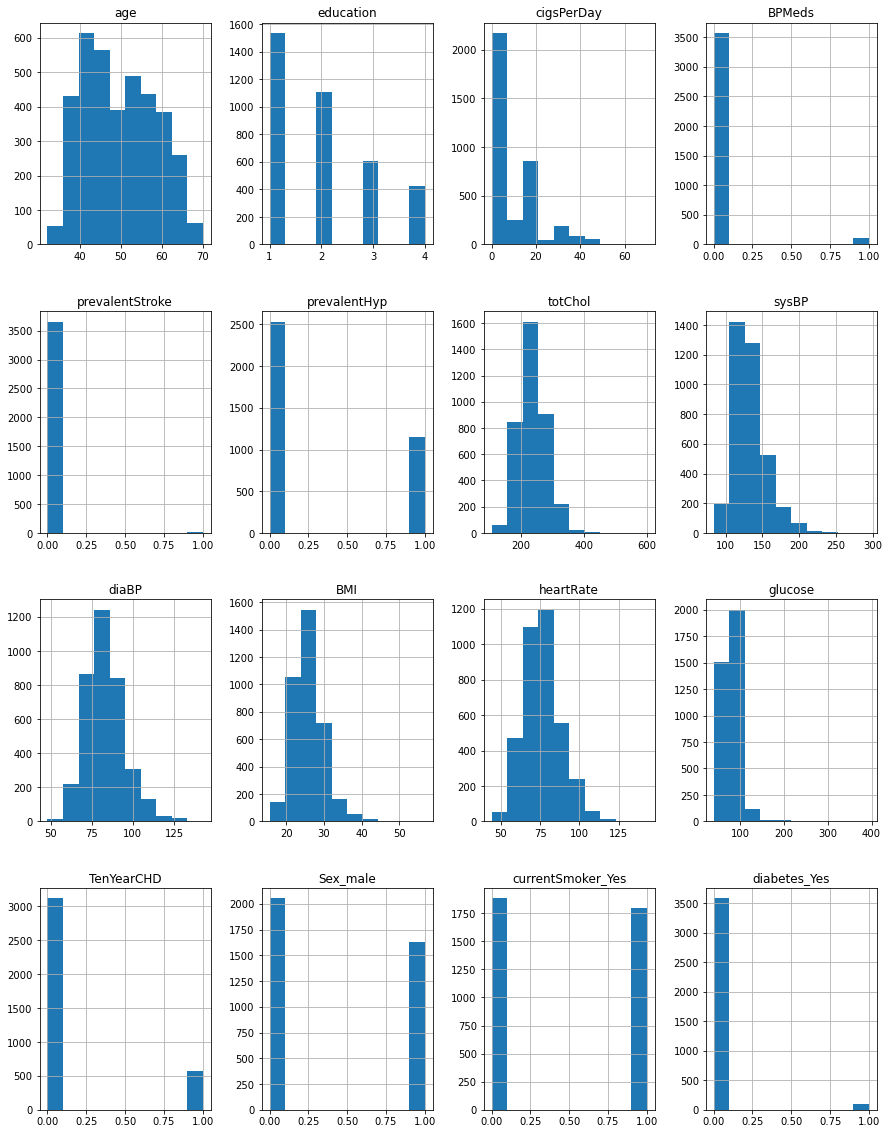

In [4]:
# Since we only have a few features, we can visualize them all in plots
fig = plt.figure(figsize=(15,20))
ax = fig.gca()
df.hist(ax=ax)


We can see some binary, dicrete and continous variables. Some of the binary variables are imbalanced, we also see that our target variable is imbalanced. Most of the continous data are right tailed. 

In [5]:
# We can see the imbalance, but it doesn't seem to be too severe, about 6 to 1.
df.TenYearCHD.value_counts(normalize=True), df.TenYearCHD.value_counts()

(0    0.846467
 1    0.153533
 Name: TenYearCHD, dtype: float64,
 0    3115
 1     565
 Name: TenYearCHD, dtype: int64)

In [6]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(
                                df.drop(['TenYearCHD'], axis=1), df['TenYearCHD'], test_size=0.3)

X_train.shape, X_test.shape

((2576, 15), (1104, 15))

In [7]:
# Run a gradient boosting model for benchmarks

gbm = GradientBoostingClassifier(loss='exponential',
                                 max_depth=1,
                                 min_samples_split= 0.80,
                                 n_estimators=100)

gbm.fit(X_train, y_train)



GradientBoostingClassifier(loss='exponential', max_depth=1,
                           min_samples_split=0.8)

In [8]:
# benchmark roc_auc_score

X_train_pred = gbm.predict_proba(X_train)[:,1]
X_test_pred = gbm.predict_proba(X_test)[:,1]

print('Train roc_auc score', roc_auc_score(y_train, X_train_pred))
print('Test roc_auc score', roc_auc_score(y_test, X_test_pred))

Train roc_auc score 0.7726056068052538
Test roc_auc score 0.6815738433478049


In [9]:
predictions = gbm.predict(X_test)
print('Accuracy of Random Forest on test set: {:.2f}'.format(gbm.score(X_test, y_test)))

Accuracy of Random Forest on test set: 0.85


In [10]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       938
           1       0.45      0.03      0.06       166

    accuracy                           0.85      1104
   macro avg       0.65      0.51      0.49      1104
weighted avg       0.79      0.85      0.79      1104



In [11]:
# benchmark roc_auc_score

X_train_pred = gbm.predict_proba(X_train)[:,1]
X_test_pred = gbm.predict_proba(X_test)[:,1]

print('Train roc_auc score', roc_auc_score(y_train, X_train_pred))
print('Test roc_auc score', roc_auc_score(y_test, X_test_pred))

Train roc_auc score 0.7726056068052538
Test roc_auc score 0.6815738433478049


### Handling Imbalanced data

In [12]:
# SMOTENC - handles discrete data for sampling

# First we need to know which are the discrete features

cat_feats = [feat for feat in X_train.columns if X_train[feat].nunique() <=5]

In [13]:
# capture the index in the dataframe columns
cat_feat_index = [cat_feats.index(x) for x in cat_feats]

cat_feat_index[:5]

[0, 1, 2, 3, 4]

In [14]:
smnc = SMOTENC(
    sampling_strategy='auto', # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=3,
    categorical_features=cat_feat_index # indeces of the columns of discrete variables
)  

# because SMOTE uses KNN, and KNN is sensible to variable magnitude, we re-scale the data

# this procedure will take a while, it also caused memory problems so train/test ratio was increased for test
X_resampled, y_resampled = smnc.fit_resample(MinMaxScaler().fit_transform(X_train), y_train)

X_train.shape, X_resampled.shape

((2576, 15), (4354, 15))

In [15]:
# check the distribution of the resampled target
# we should have 50:50 now

y_resampled.value_counts(normalize=True)

0    0.5
1    0.5
Name: TenYearCHD, dtype: float64

In [16]:
# train the model 

gbm.fit(X_resampled, y_resampled)

GradientBoostingClassifier(loss='exponential', max_depth=1,
                           min_samples_split=0.8)

In [17]:
# Now let's get the performance on train and test

X_train_preds = gbm.predict_proba(X_resampled)[:,1]
X_test_preds = gbm.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_resampled, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  0.8066382392950564
Test roc_auc:  0.4979673491406993


This model is overfitting the data

### Cost sensitive 

In [18]:
df = pd.read_csv('framingham_clean.csv')
X_train,X_test,y_train,y_test=train_test_split(
                                df.drop(['TenYearCHD'], axis=1), df['TenYearCHD'], test_size=0.3)

X_train.shape, X_test.shape

((2576, 15), (1104, 15))

In [19]:
# we have an imbalance of 85 to 15, so we use those as weights
sample_weight = np.where(y_train==1, 85, 15)

# train model
gbm.fit(X_train, y_train, sample_weight)

GradientBoostingClassifier(loss='exponential', max_depth=1,
                           min_samples_split=0.8)

In [20]:
# Now let's get the performance on train and test

X_train_preds = gbm.predict_proba(X_train)[:,1]
X_test_preds = gbm.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  0.7565401466003875
Test roc_auc:  0.7167309975191749


It looks like a very small improvement on the baseline

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
logit = LogisticRegression(penalty='l2',
                          solver='newton-cg',
                          C=1, max_iter=100).fit(X_train, y_train)

In [23]:
# Now let's get the performance on train and test

X_train_preds = logit.predict_proba(X_train)[:,1]
X_test_preds = logit.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  0.7418529473063399
Test roc_auc:  0.7223608356613281


### Calibration curves

In [24]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [25]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, X_test_preds, n_bins=11, strategy='uniform') # setting strategy to uniform means interval is of equal width

len(mean_predicted_value), len(fraction_of_positives)

(9, 9)

In [26]:
# mean probability of each interval/bin

mean_predicted_value

array([0.05627496, 0.13314834, 0.22313233, 0.31085775, 0.40187518,
       0.49318786, 0.57456787, 0.65623953, 0.76076342])

In [27]:
# fraction of observations of the minority class in each interval of possibility

fraction_of_positives

array([0.05128205, 0.10382514, 0.20111732, 0.26315789, 0.34      ,
       0.3125    , 0.6       , 1.        , 1.        ])

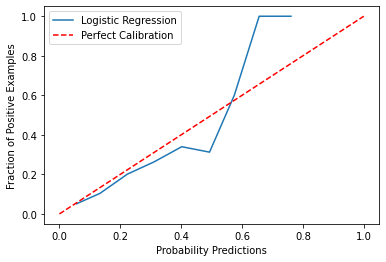

In [28]:
plt.plot(mean_predicted_value, fraction_of_positives, label='Logistic Regression')

# plot a red line
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10),
        linestyle='--', color='red', label='Perfect Calibration')

#add labels
plt.xlabel('Probability Predictions')
plt.ylabel('Fraction of Positive Examples')
plt.legend(loc='upper left')
plt.show()

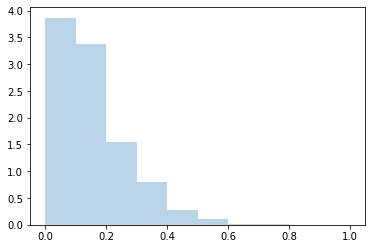

In [29]:
plt.hist(X_test_preds, range=(0,1), bins=10, density=True, stacked=True,
        alpha=0.3)
plt.show()

In [30]:
df = pd.read_csv('framingham_clean.csv')
X_train,X_test,y_train,y_test=train_test_split(
                                df.drop(['TenYearCHD'], axis=1), df['TenYearCHD'], test_size=0.3)


X_train_pred_gbm = gbm.predict_proba(X_train)[:,1]
X_test_pred_gbm = gbm.predict_proba(X_test)[:,1]

print('Train roc_auc score', roc_auc_score(y_train, X_train_pred_gbm))
print('Test roc_auc score', roc_auc_score(y_test, X_test_pred_gbm))



Train roc_auc score 0.7535289824854045
Test roc_auc score 0.7285764009745911


In [31]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, X_test_pred_gbm, n_bins=11, strategy='uniform') # setting strategy to uniform means interval is of equal width

len(mean_predicted_value), len(fraction_of_positives)

(9, 9)

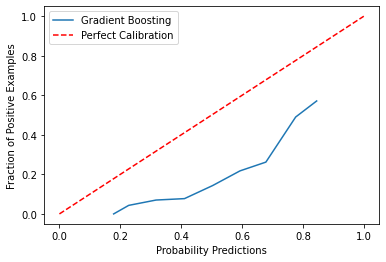

In [32]:
plt.plot(mean_predicted_value, fraction_of_positives, label='Gradient Boosting')

# plot a red line
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10),
        linestyle='--', color='red', label='Perfect Calibration')

#add labels
plt.xlabel('Probability Predictions')
plt.ylabel('Fraction of Positive Examples')
plt.legend(loc='upper left')
plt.show()

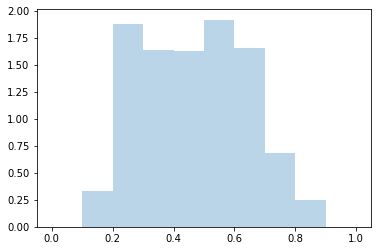

In [33]:
plt.hist(X_test_pred_gbm, range=(0,1), bins=10, density=True, stacked=True,
        alpha=0.3)
plt.show()

### Recalibration

In [34]:
# Isotonic Calibration for Gradient Boosting
clf_isotonic = CalibratedClassifierCV(gbm, cv=5, method='isotonic')
clf_isotonic.fit(X_test, y_test)
prob_isotonic = clf_isotonic.predict_proba(X_test)[:,1]


In [35]:
print('Test roc_auc score', roc_auc_score(y_test, prob_isotonic))

Test roc_auc score 0.7823940765117237


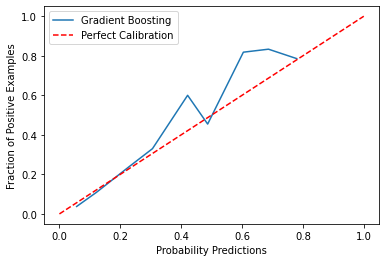

In [36]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, prob_isotonic, n_bins=11, strategy='uniform')

plt.plot(mean_predicted_value, fraction_of_positives, label='Gradient Boosting')

# plot a red line
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10),
        linestyle='--', color='red', label='Perfect Calibration')

#add labels
plt.xlabel('Probability Predictions')
plt.ylabel('Fraction of Positive Examples')
plt.legend(loc='upper left')
plt.show()

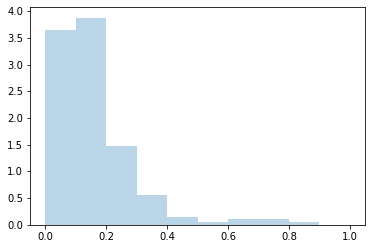

In [37]:
plt.hist(prob_isotonic, range=(0,1), bins=10, density=True, stacked=True,
        alpha=0.3)
plt.show()

### Hyperparameter Optimization

In [38]:
df = pd.read_csv('framingham_clean.csv')
X_train,X_test,y_train,y_test=train_test_split(
                                df.drop(['TenYearCHD'], axis=1), df['TenYearCHD'], test_size=0.3)

X_train.shape, X_test.shape

((2576, 15), (1104, 15))

In [39]:
from scipy import stats

In [40]:
gbm = GradientBoostingClassifier()

param_grid = dict(n_estimators=stats.randint(10, 200),
    min_samples_split=stats.uniform(0, 1),
    max_depth=stats.randint(1, 5),
    loss=('deviance', 'exponential'),)

search = RandomizedSearchCV(
    gbm, # the model
    param_grid, # hyperparam space
    scoring='roc_auc', # metric to optimize
    cv=5, # I do 2 to speed things up, 5 would be better as the dataset is quite small
    n_iter = 60, # I do 5 to speed things up, but for randomized search 60 has been shown to find the optimal hyperparameters
    random_state=5, # reproducibility
    refit=True, # this fits the model with the best hyperparams to the entire training set after the hyperparam search
)

search.fit(X_resampled,y_resampled)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=60,
                   param_distributions={'loss': ('deviance', 'exponential'),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FB10778E20>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FB106A4880>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FB10786B20>},
                   random_state=5, scoring='roc_auc')

In [41]:
search.best_params_

{'loss': 'exponential',
 'max_depth': 4,
 'min_samples_split': 0.17296183099226237,
 'n_estimators': 193}

In [42]:
# Now let's get the performance on train and test

X_train_preds = search.predict_proba(X_resampled)[:,1]
X_test_preds = search.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_resampled, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  0.9511928798359429
Test roc_auc:  0.48129602356406487
